# NLP (Natural Language Processing) with Python
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import warnings
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
#import xgboost, numpy, textblob, string
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import string


# ** Get the Data **
This is the data set provided in kaggle  https://www.kaggle.com/c/nlp-getting-started/data
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format

In [ ]:
pd.set_option('display.max_columns', 100)
file_path = 'C:\\Users\\vreddyj\\pandas\\data\\NLP_train.csv'
file_path2 = 'C:\\Users\\vreddyj\\pandas\\data\\NLP_test.csv'

train_df = pd.read_csv(file_path)
test_df = pd.read_csv(file_path2)

# EDA - Exploratory Data Analysis
Let's explore the data - Let's check out some of the stats with some plots and the built-in methods in pandas!

In [13]:
train_df.info()
train_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [15]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
print("Number of records and columns  -  train data", train_df.shape)
print("Field names :", train_df.columns.values)
#HANDLING MISSING DATA
total = train_df.isnull().sum().sort_values(ascending = False)
print("column wise total null counts",'\n',total)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
print("column wise total null count percentages",'\n', percent)

Number of records and columns  -  train data (7613, 5)
Field names : ['id' 'keyword' 'location' 'text' 'target']
column wise total null counts 
 location    2533
keyword       61
target         0
text           0
id             0
dtype: int64
column wise total null count percentages 
 location    33.272035
keyword      0.801261
target       0.000000
text         0.000000
id           0.000000
dtype: float64


In [19]:
train_df.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [20]:
train_df['length'] = train_df['text'].apply(len)
train_df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
test_df['length'] = test_df['text'].apply(len)
test_df.head()

# Data Visualization


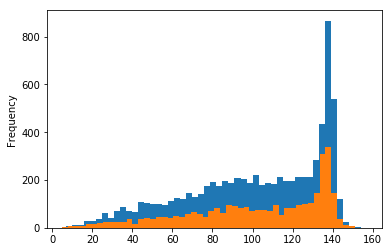

In [23]:
train_df['length'].plot(bins=50, kind='hist')
test_df['length'].plot(bins=50, kind='hist') 

In [27]:
train_df.length.describe()
#test_df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [28]:
train_df[train_df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D97259AD68>,
      dtype=object)

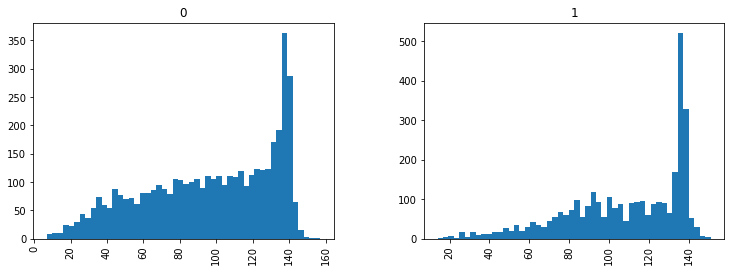

In [29]:
train_df.hist(column='length', by='target', bins=50,figsize=(12,4))

# Text Pre-processing
Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [30]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [31]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [33]:
# Check to make sure its working
train_df['text'].head(5).apply(text_process)

0    [Deeds, Reason, earthquake, May, ALLAH, Forgiv...
1        [Forest, fire, near, La, Ronge, Sask, Canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, Ruby, Alaska, smoke, wildfi...
Name: text, dtype: object

# Vectorization
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [36]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_df['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

26473


In [37]:
text4 = train_df['text'][3]
print(text4)

13,000 people receive #wildfires evacuation orders in California 


In [39]:
bow4 = bow_transformer.transform([text4])
print(bow4)
print(bow4.shape)

  (0, 144)	1
  (0, 2334)	1
  (0, 14502)	1
  (0, 22409)	1
  (0, 22635)	1
  (0, 23345)	1
  (0, 26071)	1
(1, 26473)


In [40]:
print(bow_transformer.get_feature_names()[144])
print(bow_transformer.get_feature_names()[26071])

13000
wildfires


In [41]:
messages_bow = bow_transformer.transform(train_df['text'])

In [42]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (7613, 26473)
Amount of Non-Zero occurences:  75006


In [43]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


# TF-IDF, using scikit-learn's TfidfTransformer
After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.
So what is TF-IDF?
TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 26071)	0.4024513325168046
  (0, 23345)	0.4718026141633829
  (0, 22635)	0.25921479580657425
  (0, 22409)	0.39780696282539063
  (0, 14502)	0.3391667965318131
  (0, 2334)	0.2781109881741682
  (0, 144)	0.44453648958637354


In [46]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['wildfires']])

5.948759890378168
7.539848664144072


In [47]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(7613, 26473)


# Training a model
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with:

In [49]:
from sklearn.naive_bayes import MultinomialNB
disaster_detect_model = MultinomialNB().fit(messages_tfidf, train_df['target'])

In [50]:
print('predicted:', disaster_detect_model.predict(tfidf4)[0])
print('expected:', train_df.target[3])

predicted: 1
expected: 1


In [51]:
all_predictions = disaster_detect_model.predict(messages_tfidf)
print(all_predictions)

[1 1 1 ... 1 1 1]


# Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [53]:
from sklearn.metrics import classification_report
print (classification_report(train_df['target'], all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      4342
           1       0.97      0.83      0.89      3271

   micro avg       0.91      0.91      0.91      7613
   macro avg       0.93      0.90      0.91      7613
weighted avg       0.92      0.91      0.91      7613



In [67]:
# Test accuracy
print("All data accuracy is: ")
print(accuracy_score(train_df['target'], all_predictions))

All data accuracy is: 
0.9143570208853278


Train test data split

In [55]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(train_df['text'], train_df['target'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

6090 1523 7613


Creating a Data Pipeline
Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [56]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [57]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001D9727659D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [69]:
predictions_train = pipeline.predict(msg_train)
predictions_test = pipeline.predict(msg_test)

In [71]:
print(classification_report(predictions_train,label_train))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3853
           1       0.84      0.97      0.90      2237

   micro avg       0.92      0.92      0.92      6090
   macro avg       0.91      0.93      0.92      6090
weighted avg       0.93      0.92      0.92      6090



In [72]:
print(classification_report(predictions_test,label_test))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1025
           1       0.62      0.83      0.71       498

   micro avg       0.78      0.78      0.78      1523
   macro avg       0.76      0.79      0.76      1523
weighted avg       0.81      0.78      0.78      1523



In [75]:
# Test accuracy
print("NB-Train data accuracy is: ")
print(accuracy_score(label_train, predictions_train))
# Test accuracy
print("NB- test data accuracy is: ")
print(accuracy_score(label_test, predictions_test))

Train data accuracy is: 
0.9198686371100164
test data accuracy is: 
0.7754432042022325


In [94]:
msg_ftest = test_df['text']

let us predict the actual testdata/the goal of the competition is to predict for this data set

In [77]:
predictions_ftest = pipeline.predict(msg_ftest)

let us try random forest model

In [96]:
# RandomForestClassifier pipeline
pipeline_rf = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [97]:
pipeline_rf.fit(msg_train,label_train)
predictions_train = pipeline_rf.predict(msg_train)
predictions_test = pipeline_rf.predict(msg_test)

In [98]:
print(classification_report(predictions_train,label_train))
# Test accuracy
print("RF - Train data accuracy is: ")
print(accuracy_score(label_train, predictions_train))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3633
           1       0.94      0.99      0.97      2457

   micro avg       0.97      0.97      0.97      6090
   macro avg       0.97      0.98      0.97      6090
weighted avg       0.97      0.97      0.97      6090

RF - Train data accuracy is: 
0.9720853858784894


In [99]:
print(classification_report(predictions_test,label_test))
# Test accuracy
print("RF - Test data accuracy is: ")
print(accuracy_score(label_test, predictions_test))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1052
           1       0.56      0.80      0.66       471

   micro avg       0.75      0.75      0.75      1523
   macro avg       0.73      0.76      0.73      1523
weighted avg       0.79      0.75      0.75      1523

RF - Test data accuracy is: 
0.7458962573867367


let us predict the actual testdata/the goal of the competition is to predict for this data set

In [100]:
predictions_ftest = pipeline_rf.predict(msg_ftest)

# loading the results in to csv file
rad the sample file from desktop
make a data frame and write the target predictions and 
write the final results as a CSV

In [101]:
file_path3 = "C:\\Users\\vreddyj\\Desktop\\BM_2018\\Ineuron\\Natural-Language-Processing-master\\NLP-Kaggle\\submission.csv"
sample_submission = pd.read_csv(file_path3)

In [102]:
sample_submission["target"] = predictions_ftest

In [103]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [82]:
#naive bias results
sample_submission.to_csv("submission_371040.csv", index=False)
#File saved in path C:\VTRoot\HarddiskVolume4\Users\vreddyj

In [104]:
#random forest results
sample_submission.to_csv("submission_rf.csv", index=False)
#File saved in path C:\VTRoot\HarddiskVolume4\Users\vreddyj

In [91]:
#https://medium.com/@waliamrinal/saving-a-pandas-dataframe-as-a-csv-file-4f8b74b7a1bc
sample_submission.to_csv(r'C:\\Users\\vreddyj\\Desktop\\submission.csv', index=False)

In [92]:
sample_submission.to_csv(r'C:\Users\vreddyj\Desktop\submission3.csv', index=False)
#file save in path C:\VTRoot\HarddiskVolume4\Users\vreddyj\Desktop

In [93]:
sample_submission.to_csv(r'C:\Users\vreddyj\Desktop\file.csv', index=False)